In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor


file_path = '/Users/chiangyishiuan/Desktop/ 68700 AI For Business Decisions/AIBD-final project'

In [2]:
# airbnb_df = pd.read_csv(file_path + 'airbnb_Washington.csv')
airbnb_df = pd.read_csv('airbnb_Washington.csv')
airbnb_df.head()

,Airbnb Host ID,Airbnb Property ID,City_x,superhost_period_all,scrapes_in_period,Scraped Date,superhost_observed_in_period,host_is_superhost_in_period,superhost_ratio,prev_superhost_period_all,...,prev_host_is_superhost2,prev_year_superhosts,booked_days_period_city,revenue_period_city,booked_days_period_tract,revenue_period_tract,tract_booking_share,tract_revenue_share,time_to_date_mean,prev_time_to_date_mean
0,3768.0,3192.0,Washington,7.0,9.0,2017-02-01,9.0,0.0,0.0,6.0,...,0.0,0.0,129250.0,19381223.0,1102.0,106663.0,0.008526,0.005503,15.000000,NaN
1,3768.0,3192.0,Washington,8.0,14.0,2017-05-01,14.0,0.0,0.0,7.0,...,0.0,0.0,118144.0,17089974.0,1228.0,110010.0,0.010394,0.006437,10.909091,15.000000
2,3768.0,3192.0,Washington,9.0,10.0,2017-08-08,10.0,0.0,0.0,8.0,...,0.0,0.0,121747.0,16663763.0,1375.0,114104.0,0.011294,0.006847,NaN,10.909091
3,3768.0,3192.0,Washington,11.0,17.0,2018-02-05,17.0,0.0,0.0,10.0,...,0.0,0.0,173120.0,24437011.0,1795.0,149928.0,0.010369,0.006135,NaN,NaN
4,3768.0,3297.0,Washington,5.0,10.0,2016-08-16,10.0,0.0,0.0,4.0,...,0.0,0.0,76864.0,10118493.0,666.0,76059.0,0.008665,0.007517,NaN,NaN


# Part 1: Preprocessing

- Define columns type
- Handle null value

In [3]:
# Define columns type
target = 'occupancy_rate'
date_cols = ['Scraped Date', 'Created Date']
drop_cols = ['City_x', 'City_y', 'Zipcode', 'Property Type.1']
categorical_cols = ['Property Type', 'Listing Type', 'Neighborhood']
continuous_cols =  [item for item in airbnb_df.columns if item not in [target] + date_cols + drop_cols + categorical_cols]

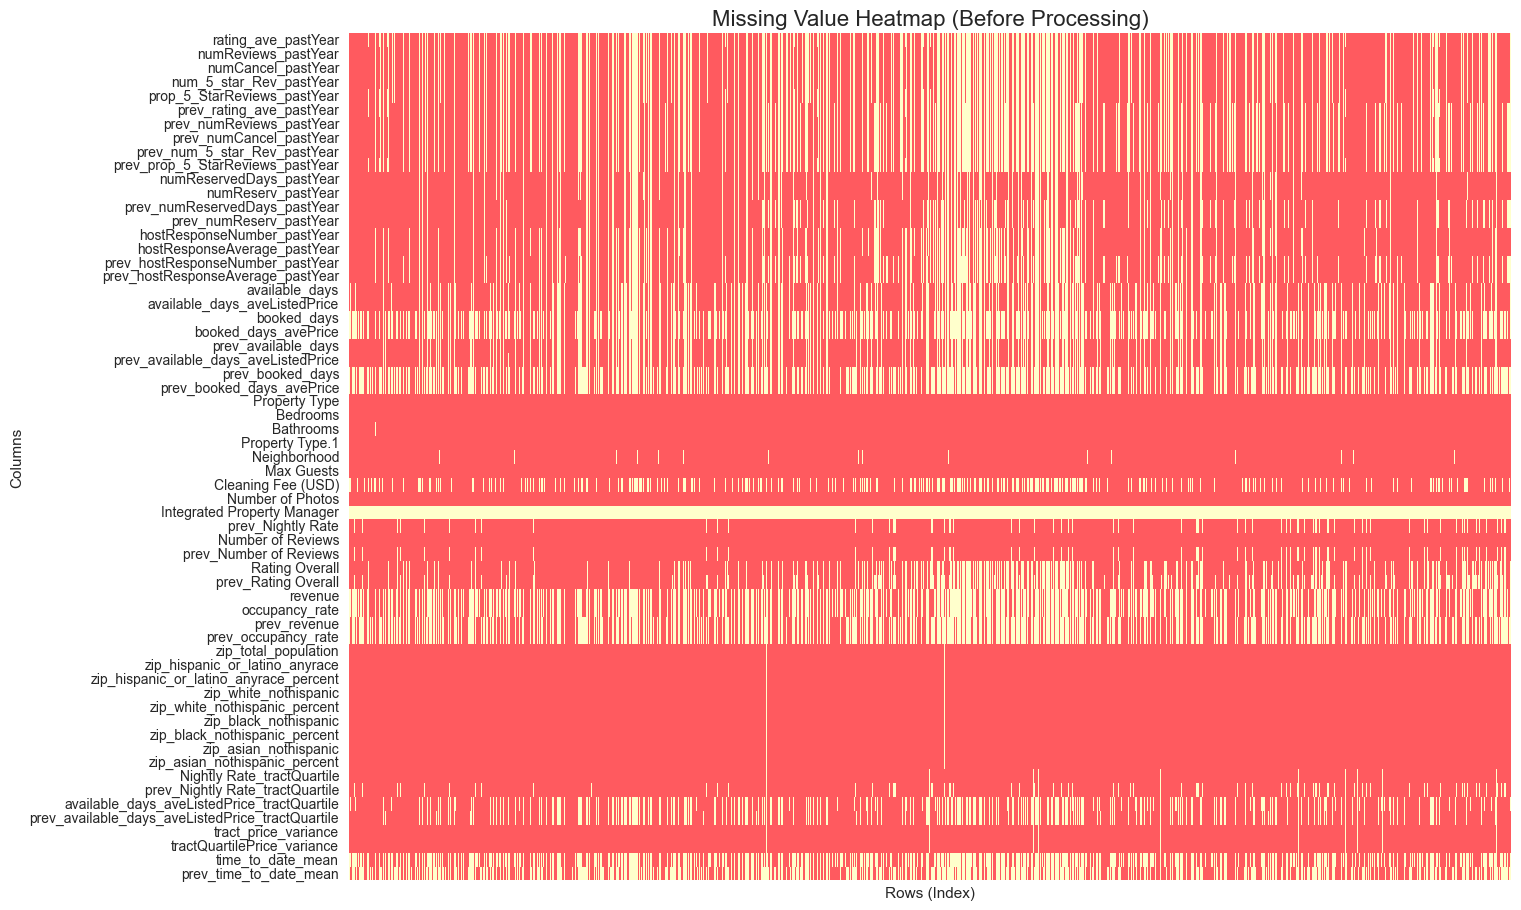

In [4]:
# Only choose the columns that have at lease one null cell
columns_with_nulls = airbnb_df.columns[airbnb_df.isnull().any()]
filtered_data = airbnb_df[columns_with_nulls]

plt.figure(figsize=(15, 11))

# Plot heatmap
sns.heatmap(
    filtered_data.isnull().T,
    cbar=False,
    cmap=["#FF5A5F", "#FFFFCC"],
    yticklabels=True,
    xticklabels=False
)

plt.title("Missing Value Heatmap (Before Processing)", fontsize=16)
plt.xlabel("Rows (Index)")
plt.ylabel("Columns")

plt.show()

In [5]:
# Handle null value
airbnb_data = airbnb_df.copy()

# 1. Drop the rows and columns with all null
print('Shape of df before process: ', airbnb_data.shape)
airbnb_data = airbnb_data.dropna(axis=1, how='all')
airbnb_data = airbnb_data.dropna(axis=0, how='all')
print('Shape of df after  process: ', airbnb_data.shape)

# 2. Drop null target rows
print('\nRows of df before drop null target: ', airbnb_data.shape[0])
airbnb_data = airbnb_data.dropna(subset=["occupancy_rate"])
print('Rows of df before drop null target: ', airbnb_data.shape[0])

# 3. Fill in value into null cells
print('\nProportion of null data: ', airbnb_data.isnull().sum().sum() / (airbnb_data.shape[0] * airbnb_data.shape[1]))
print('Sum of null cells before process: ', airbnb_data.isnull().sum().sum())

# Traverse Airbnb Host ID
for host_id, group in airbnb_data.groupby("Airbnb Host ID"):
    all_empty = True  # Flag of whether the data of the Host is completely empty

    # categorical data
    for col in categorical_cols:
        if col in group.columns:
            mode = group[col].mode()  # Find the value that occurs most times

            # If mode exists, fill in mode, otherwise fill in Unknown
            if not mode.empty:
                airbnb_data.loc[group.index, col] = group[col].fillna(mode[0])
                all_empty = False
            else:
                airbnb_data.loc[group.index, col] = group[col].fillna("Unknown")

    # continuous data
    for col in continuous_cols:
        if col in group.columns:
            mean = group[col].mean()  # Calculate the mean

            # If mean exists, fill in mean, otherwise fill in 0
            if not np.isnan(mean):
                airbnb_data.loc[group.index, col] = group[col].fillna(mean)
                all_empty = False
            else:
                airbnb_data.loc[group.index, col] = group[col].fillna(0)

    # If the entire Airbnb Host ID information is empty
    if all_empty:
        for col in categorical_cols:
            airbnb_data.loc[group.index, col] = "Unknown"
        for col in continuous_cols:
            airbnb_data.loc[group.index, col] = 0

print('Sum of null cells after  process: ', airbnb_data.isnull().sum().sum())

Shape of df before process:  (133741, 111)
Shape of df after  process:  (133741, 110)

Rows of df before drop null target:  133741
Rows of df before drop null target:  71690

Proportion of null data:  0.030943456041796116
Sum of null cells before process:  244017
Sum of null cells after  process:  0


# Part 2: Cluster data by Nightly Rate

In order to provide better customized services for different types of houses, we first group them according to the price of each house. Use this to find out business strategies at different price points.

### a. Find out how many groups the data should be divided into

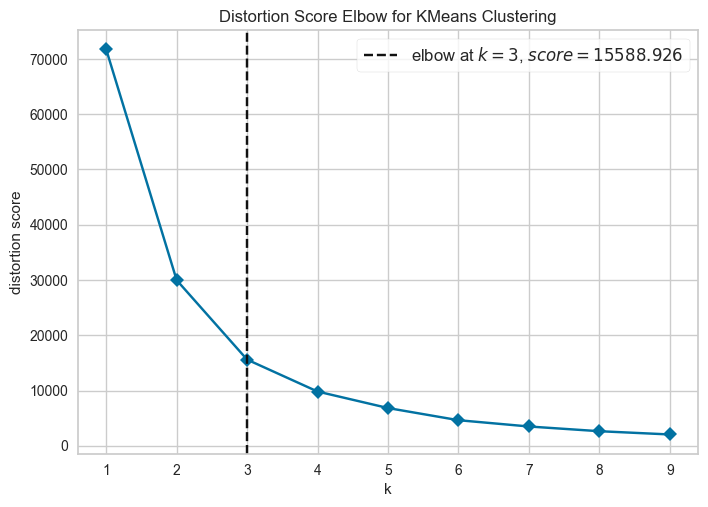

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
# Select the relevant features for clustering
rate_df = airbnb_data[['Nightly Rate']].copy()

# Standardize the features
scaler = StandardScaler()
standardized_rate = scaler.fit_transform(rate_df)

# Initialize the KMeans model
model = KMeans(random_state=12345)

# Use KElbowVisualizer to find the optimal number of clusters
visualizer = KElbowVisualizer(model, k=(1, 10), metric='distortion', timings=False)

# Fit the visualizer
visualizer.fit(standardized_rate)

# Render the visualization
visualizer.show()

### b. Divided the data into different cluster

In [7]:
# Apply K-means clustering without standardization
kmeans = KMeans(n_clusters=3, random_state=12345)
rate_df['cluster'] = kmeans.fit_predict(rate_df)

# Calculate the average values for each cluster
cluster_analysis = rate_df.groupby('cluster').mean()
cluster_analysis

,Nightly Rate
cluster,
0,119.798622
1,342.751973
2,873.546967


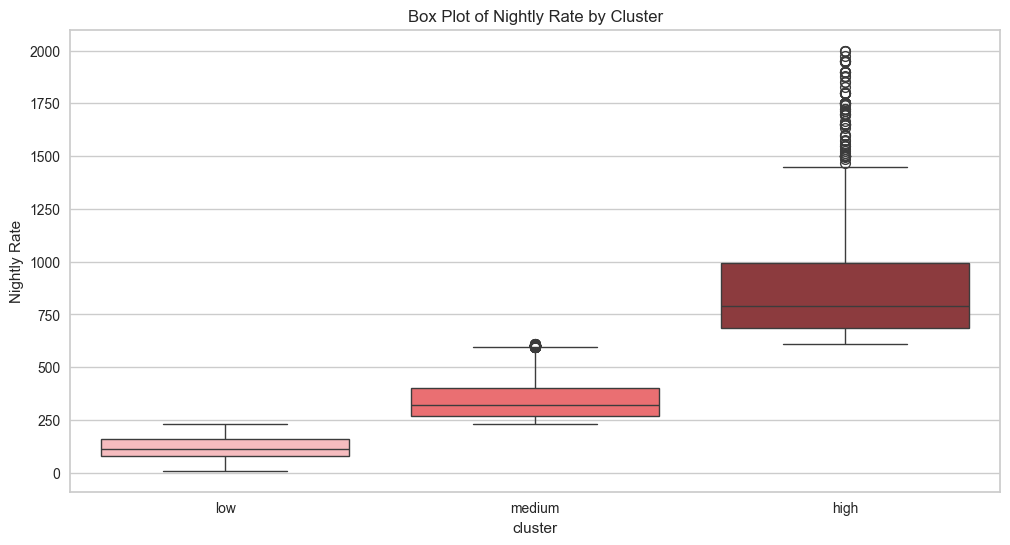

In [8]:
# Rename the cluster, set the display order and color
rate_df["cluster"] = rate_df["cluster"].replace({0: "low", 1: "medium", 2: "high"})
order = ["low", "medium", "high"]
palette = {"low": "#FFB3B6", "medium": "#FF5A5F", "high": "#992E31"}

plt.figure(figsize=(12, 6))
sns.boxplot(x="cluster", y="Nightly Rate", data=rate_df, order=order, palette=palette, hue="cluster", dodge=False, legend=False)

plt.title("Box Plot of Nightly Rate by Cluster")
plt.ylabel("Nightly Rate")
plt.show()

In [9]:
# Divide the dataset into three dataframe
airbnb_data['cluster'] = rate_df['cluster']

low_rate_host = airbnb_data[airbnb_data['cluster'] == 'low']
medium_rate_host = airbnb_data[airbnb_data['cluster'] == 'medium']
high_rate_host = airbnb_data[airbnb_data['cluster'] == 'high']

In [10]:
# Use the hight rate cluster to analysis
host_data = low_rate_host.copy()

# Prepare data to analysis
feature_df = host_data.drop(columns = [target] + ['Airbnb Property ID', 'cluster'] + date_cols + drop_cols)
feature_df = pd.get_dummies(feature_df, columns=categorical_cols, drop_first=False)

# host_data 包含所有欄位，記得要換成自己的 price level 的資料
# feature_df 包含所有要訓練的欄位跟Airbnb Host ID（不包含occupancy_rate）
    # 要訓練的話記得拿掉 Airbnb Host ID：X = feature_df.drop(columns = ['Airbnb Host ID'])
# occupancy_rate 要拿 host_data[target]

# Part 3: Data analysis

### a. Price and rating sensitivity
The impact of Nightly Rate and rating_ave_pastYear on occupation_rate at different price level


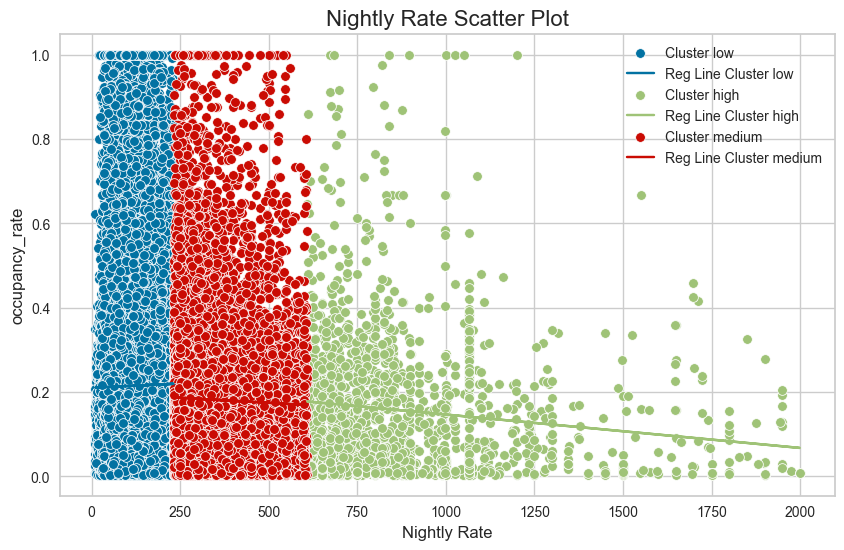

Nightly Rate Coefficients:
Cluster low: Coefficient = 0.000040
Cluster high: Coefficient = -0.000079
Cluster medium: Coefficient = -0.000048


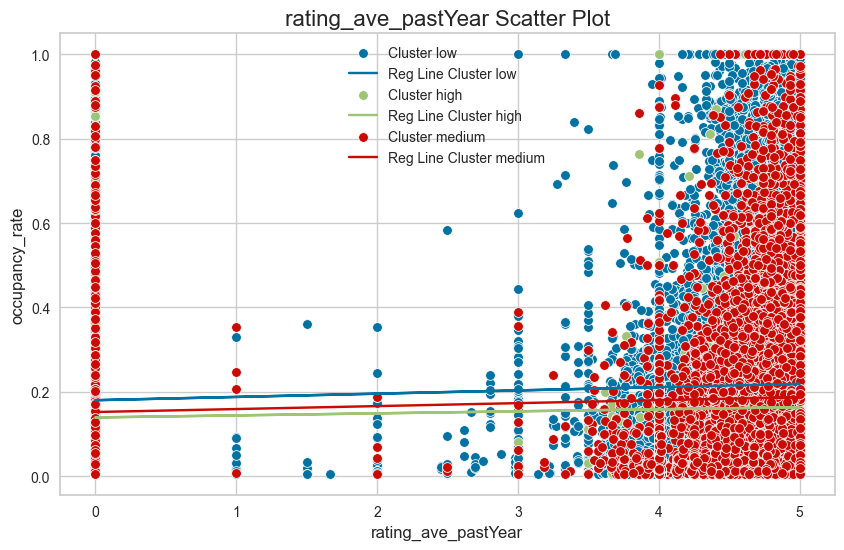

rating_ave_pastYear Coefficients:
Cluster low: Coefficient = 0.007739
Cluster high: Coefficient = 0.004847
Cluster medium: Coefficient = 0.007018


In [11]:
def coef_analysis(df, x_col, y_col):

    plt.figure(figsize=(10, 6))
    
    clusters = df['cluster'].unique()

    # Dict for storing coefficients
    regression_coefficients = {}
    
    # Traverse all clusters and plot the scatter plot and regression line
    for cluster in clusters:
        cluster_data = df[df['cluster'] == cluster]
        
        # Set x and y
        x = cluster_data[x_col].values.reshape(-1, 1)
        y = cluster_data[y_col].values
        
        # Define model
        model = LinearRegression()
        model.fit(x, y)
        coef = model.coef_[0] 
        
        # Store the regression coefficients
        regression_coefficients[cluster] = coef
        
        # Plot
        sns.scatterplot(x=cluster_data[x_col], y=cluster_data[y_col], label=f'Cluster {cluster}')
        plt.plot(cluster_data[x_col], model.predict(x), label=f'Reg Line Cluster {cluster}')
    
    # Add labels and legend
    plt.title(x_col + " Scatter Plot", fontsize=16)
    plt.ylabel(y_col, fontsize=12)
    plt.xlabel(x_col, fontsize=12)
    plt.legend()
    plt.show()

    # Print coefficients
    print(x_col + " Coefficients:")
    for cluster, coef in regression_coefficients.items():
        print(f"Cluster {cluster}: Coefficient = {coef:.6f}")

coef_analysis(airbnb_data, 'Nightly Rate', 'occupancy_rate')
coef_analysis(airbnb_data, 'rating_ave_pastYear', 'occupancy_rate')

### b. What variables affect “occupancy_rate” significantly

- Significant features
  - Positive:
    - booked_days:             0.00681
    - rating_ave_pastYear:     0.00526
    - Max Guests:              0.00135
    - prev_available_days:     0.00037
    - prev_numReserv_pastYear: 0.00025
    - prev_Number of Reviews:  0.00019
    - Rating Overall:          0.00013
    - prev_revenue:            0.00000
    - revenue_period_tract:    0.00000

  - Negative:
    - tract_revenue_share:           -1.11649
    - Pets Allowed:                  -0.00594
    - prev_rating_ave_pastYear:      -0.00478
    - prev_booked_days:              -0.00240
    - available_days:                -0.00193
    - prev_year_superhosts:          -0.00152
    - prev_Rating Overall:           -0.00028
    - prev_num_5_star_Rev_pastYear:  -0.00027
    - Number of Photos:              -0.00026
    - prev_time_to_date_mean:        -0.00025
    - Number of Reviews:             -0.00021
    - Cleaning Fee (USD):            -0.00011
    - prev_booked_days_avePrice:     -0.00007
    - time_to_date_mean:             -0.00004
    - booked_days_period_tract:      -0.00002
    - tract_housing_units:           -0.00000

- Summary
  - Positive:
  - Negative:

In [12]:
X = feature_df.drop(columns = ['Airbnb Host ID'])
y = host_data[target]

X = sm.add_constant(X)  # Add a constant for the intercept

for col in X.columns:
  if X[col].dtype == 'bool':
    X[col] = X[col].astype(int)

# Build the statsmodels OLS regression model
linear_model = sm.OLS(y, X).fit()

# Summarize the results
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         occupancy_rate   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     492.8
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:16:27   Log-Likelihood:                 45305.
No. Observations:               54937   AIC:                        -9.012e+04
Df Residuals:                   54693   BIC:                        -8.795e+04
Df Model:                         243                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
superhost_period_all                                -2.4640      2.261     -1.090      0.276      -6.895       1.967
scrapes_in_period                                    0.0003      0.000      1.829      0.067   -1.89e-05       0.001
superhost_observed_in_period                        -0.0003      0.000     -2.040      0.041      -0.001   -1.16e-05
host_is_superhost_in_period                          0.0042      0.007      0.574      0.566      -0.010       0.018
superhost_ratio                                     -0.0108      0.018     -0.616      0.538      -0.045       0.024
prev_superhost_period_all                            2.4642      2.261      1.090      0.276      -1.967       6.895
prev_host_is_superhost_in_period                     0.0010      0.001      0.684      0.494      -0.002       0.004
prev_scrapes_in_period                            3.271e-05   8.02e-06      4.076      0.000     1.7e-05    4.84e-05
superhost_date_diff                                 -4.9499      4.541     -1.090      0.276     -13.851       3.951
Superhost                                            0.0034      0.007      0.465      0.642      -0.011       0.018
prev_host_is_superhost                               0.0007      0.001      0.458      0.647      -0.002       0.004
superhost_change                                    -0.0011      0.001     -1.043      0.297      -0.003       0.001
superhost_change_lose_superhost                     -0.0023      0.003     -0.752      0.452      -0.008       0.004
superhost_change_gain_superhost                      0.0013      0.003      0.423      0.672      -0.005       0.007
rating_ave_pastYear                                  0.0053      0.002      3.216      0.001       0.002       0.008
numReviews_pastYear                                 -0.0001   6.59e-05     -2.265      0.024      -0.000   -2.01e-05
numCancel_pastYear                                  -0.0005      0.000     -1.032      0.302      -0.001       0.000
num_5_star_Rev_pastYear                              0.0002   8.24e-05      1.897      0.058   -5.18e-06       0.000
prop_5_StarReviews_pastYear                         -0.0090      0.007     -1.298      0.194      -0.023       0.005
prev_rating_ave_pastYear                            -0.0048      0.002     -2.983      0.003      -0.008      -0.002
prev_numReviews_pastYear                             0.0002   7.17e-05      3.434      0.001       0.000       0.000
prev_numCancel_pastYear                           2.617e-05      0.001      0.051      0.959      -0.001       0.001
prev_num_5_star_Rev_pastYear                        -0.0003   8.92e-05     -3.006      0.003      -0.000   -9.33e-05
prev_prop_5_StarReviews_pastYear         

In [13]:
# Extract the summary table from the regression model
summary_table = linear_model.summary2().tables[1]

# Filter rows where the p-value < 0.05
significant_vars = summary_table[summary_table['P>|t|'] < 0.05]

# Sort significant variables by coefficient (positive impact)
positive_impact = significant_vars[significant_vars['Coef.'] > 0].sort_values(by='Coef.', ascending=False)

# Sort significant variables by coefficient (negative impact)
negative_impact = significant_vars[significant_vars['Coef.'] < 0].sort_values(by='Coef.')

# Print results
print("Positive Impact Variables:")
print(positive_impact)

print("\nNegative Impact Variables:")
print(negative_impact)

Positive Impact Variables:
                                                    Coef.      Std.Err.  \
prev_occupancy_rate                          3.650417e-01  7.703919e-03   
booked_days                                  6.807021e-03  5.450767e-05   
rating_ave_pastYear                          5.257836e-03  1.635006e-03   
available_days_aveListedPrice_tractQuartile  4.578695e-03  1.015175e-03   
Max Guests                                   1.350562e-03  3.914328e-04   
prev_available_days                          3.706476e-04  1.594584e-05   
prev_numReviews_pastYear                     2.460675e-04  7.166283e-05   
prev_Number of Reviews                       1.859440e-04  3.004861e-05   
Rating Overall                               1.295058e-04  5.923302e-05   
prev_scrapes_in_period                       3.270734e-05  8.024757e-06   
prev_revenue                                 1.601582e-06  4.726268e-07   
booked_days_period_city                      4.348341e-07  1.111464e-07  

### c. Super host transition
Does it affect the occupancy rate if it is a continuous superhost?<br>
Superhost | Mean Occupancy Rate | Count |<br>
False | 0.204306 |  31682 |<br>
True  | 0.229583 |  23255 |

In [14]:
# Change the values to bool
host_data["host_is_superhost_in_period"] = host_data["host_is_superhost_in_period"].astype(bool)
host_data["prev_host_is_superhost_in_period"] = host_data["prev_host_is_superhost_in_period"].astype(bool)

# 1. The impact of whether it is superhost on occupancy
superhost_effect = host_data.groupby("host_is_superhost_in_period")["occupancy_rate"].agg(["mean", "count"]).reset_index()
superhost_effect.columns = ["Superhost", "Mean Occupancy Rate", "Count"]

print("Analysis 1: Superhost Effect on Occupancy Rate")
print(superhost_effect)

# 2. The impact of continuous superhost on occupancy
grouped = host_data.groupby("Airbnb Host ID")

analysis_results = []
for host_id, group in grouped:
    # Sorting to ensure analysis is done sequentially by the period order
    group = group.sort_values(by="superhost_period_all")

    # Extract information for each period
    periods = group["superhost_period_all"].tolist()
    superhost_status = group["host_is_superhost_in_period"].tolist()
    occupancy_rates = group["occupancy_rate"].tolist()

    # Initialize statistical variables
    change_stats = {
        "True -> True": {"total_rate": 0, "total_change": 0, "count": 0},
        "True -> False": {"total_rate": 0, "total_change": 0, "count": 0},
        "False -> True": {"total_rate": 0, "total_change": 0, "count": 0},
        "False -> False": {"total_rate": 0, "total_change": 0, "count": 0},
    }

    for i in range(1, len(periods)):
        # Get the status of the current and previous period
        prev_status = superhost_status[i - 1]
        current_status = superhost_status[i]

        # Determine the type of change
        change_type = f"{prev_status} -> {current_status}"

        # Calculate occupancy_rate delta
        rate_change = occupancy_rates[i] - occupancy_rates[i - 1]

        # 更新數據
        if change_type in change_stats:
            change_stats[change_type]["total_rate"] += occupancy_rates[i]
            change_stats[change_type]["total_change"] += rate_change
            change_stats[change_type]["count"] += 1

    # 计算平均变化量并存储结果
    for change_type, stats in change_stats.items():
        avg_rate = stats["total_rate"] / stats["count"] if stats["count"] > 0 else 0
        avg_change = stats["total_change"] / stats["count"] if stats["count"] > 0 else 0
        analysis_results.append({
            "Host ID": host_id,
            "Change Type": change_type,
            "Average Occupancy Rate": avg_rate,
            "Total Change in Occupancy Rate": stats["total_change"],
            "Average Change per Transition": avg_change,
            "Transition Count": stats["count"]
        })

results_df = pd.DataFrame(analysis_results)

# 按變化量降序排序
results_df = results_df.sort_values(by="Total Change in Occupancy Rate", ascending=False)

print("\nAnalysis 2: Superhost Period Changes and Consecutive Effect")

# 印出结果
results_df


Analysis 1: Superhost Effect on Occupancy Rate
   Superhost  Mean Occupancy Rate  Count
0      False             0.204306  31682
1       True             0.229583  23255

Analysis 2: Superhost Period Changes and Consecutive Effect


,Host ID,Change Type,Average Occupancy Rate,Total Change in Occupancy Rate,Average Change per Transition,Transition Count
13291,23246212.0,False -> False,0.383123,1.371320,0.114277,12
18326,44453549.0,False -> True,0.797297,1.184970,0.592485,2
27640,163014186.0,True -> True,0.448332,1.075188,0.097744,11
8318,10110842.0,False -> True,1.000000,1.017949,0.508974,2
22547,78198160.0,False -> False,0.350067,0.995868,0.331956,3
...,...,...,...,...,...,...
27139,148858753.0,False -> False,0.090035,-1.033045,-0.516522,2
13488,23714240.0,True -> True,0.319761,-1.053282,-0.045795,23
14559,27211012.0,False -> False,0.104327,-1.145638,-0.163663,7
6162,6488932.0,False -> True,0.054259,-1.205399,-0.602700,2


/var/folders/1p/wt8rg6m50c16zdgg_l9lx0h40000gn/T/ipykernel_7860/1399148383.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Change Type", y="Average Change per Transition", data=change_type_total, palette="coolwarm")


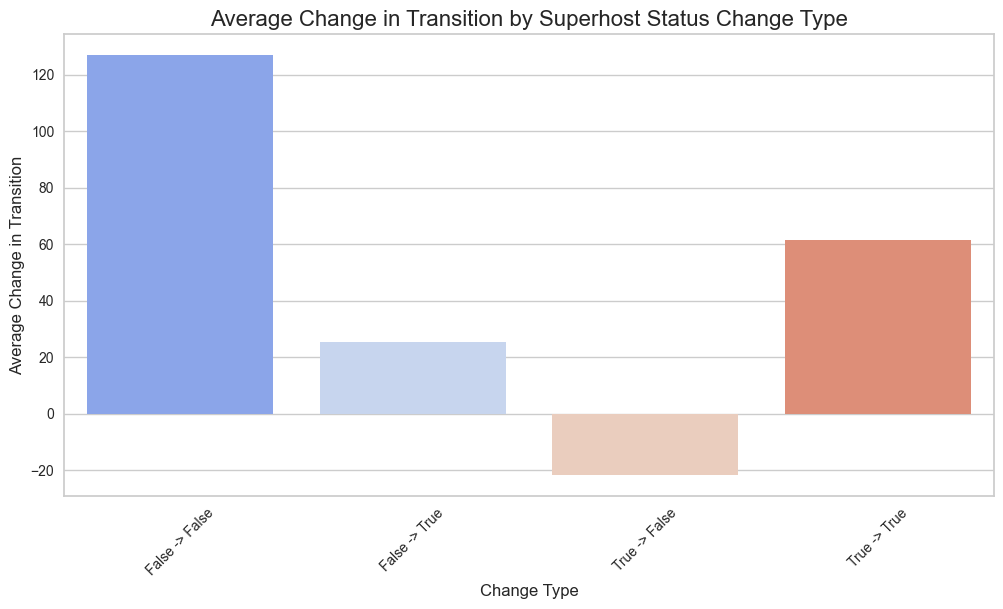

In [15]:
# 計算每種 Change Type 的總變化量
change_type_total = results_df.groupby("Change Type")["Average Change per Transition"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x="Change Type", y="Average Change per Transition", data=change_type_total, palette="coolwarm")
plt.title("Average Change in Transition by Superhost Status Change Type", fontsize=16)
plt.xlabel("Change Type", fontsize=12)
plt.ylabel("Average Change in Transition", fontsize=12)
plt.xticks(rotation=45)
plt.show()

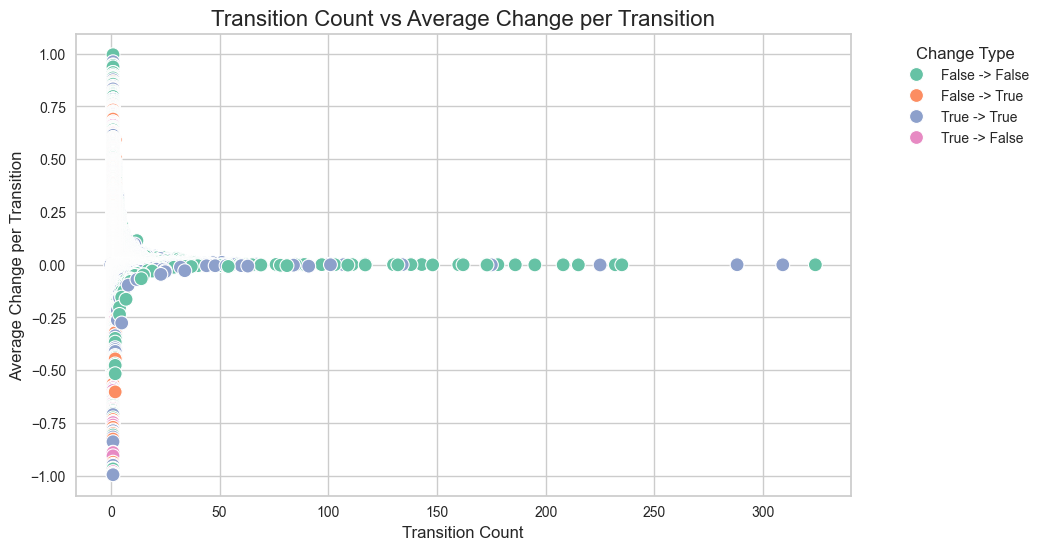

In [16]:
# 繪製 scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Transition Count", y="Average Change per Transition", hue="Change Type", data=results_df, palette="Set2", s=100)
plt.title("Transition Count vs Average Change per Transition", fontsize=16)
plt.xlabel("Transition Count", fontsize=12)
plt.ylabel("Average Change per Transition", fontsize=12)
plt.legend(title="Change Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

### d. What features will affect whether there is a superhost?

- Positive:
    - host_is_superhost_in_period       4.146343e-01
    - Superhost                         4.146340e-01
    - superhost_change_gain_superhost   1.707319e-01
    - pprev_host_is_superhost_in_period 7.317084e-02
    - prev_host_is_superhost            7.317068e-02
    - prev_year_superhosts              2.439026e-02
    - rating_ave_pastYear               1.477571e-08
    - prev_hostResponseNumber_pastYear  8.760380e-10
    - tract_unique_prices               5.785996e-10
    - hostResponseAverage_pastYear      4.112365e-10
    - prev_Nightly Rate                 1.140318e-10
    - tract_price_variance              1.042320e-13

- Negative:
    - superhost_change_lose_superhost -1.707317e-01
    - prev_host_is_superhost2         -2.439026e-02
    - prev_host_is_superhost1         -2.439026e-02 
    - superhost_ratio                 -1.384673e-07
    - superhost_change                -7.234842e-08
    - prev_rating_ave_pastYear        -1.626008e-08
    - hostResponseNumber_pastYear     -5.126638e-10
    - tract_housing_units             -1.388506e-11
    - census_tract                    -4.015223e-17

In [17]:
# Define the dependent variable (Superhost) and independent variables
X = feature_df.drop(columns = ['Airbnb Host ID'])
y = feature_df['Superhost']  # Dependent variable

# Add a constant for the intercept
X = sm.add_constant(X)

for col in X.columns:
  if X[col].dtype == 'bool':
    X[col] = X[col].astype(int)

# Build the OLS regression model
ols_model = sm.OLS(y, X).fit()

# Summarize the results
# print(ols_model.summary())

# Extract p-values and coefficients
summary_table = ols_model.summary2().tables[1]

# Filter significant variables (p-value < 0.05)
significant_vars = summary_table[summary_table['P>|t|'] < 0.05]

# Separate and sort positive and negative impact variables
positive_impact = significant_vars[significant_vars['Coef.'] > 0].sort_values(by='Coef.', ascending=False)
negative_impact = significant_vars[significant_vars['Coef.'] < 0].sort_values(by='Coef.')

# Print results
print("\nPositive Impact Variables (P-Value < 0.05):\n", positive_impact)
print("\nNegative Impact Variables (P-Value < 0.05):\n", negative_impact)


Positive Impact Variables (P-Value < 0.05):
                                          Coef.      Std.Err.             t  \
host_is_superhost_in_period       4.146343e-01  2.277218e-08  1.820794e+07   
Superhost                         4.146340e-01  2.281788e-08  1.817145e+07   
superhost_change_gain_superhost   1.707319e-01  9.568923e-09  1.784233e+07   
prev_host_is_superhost_in_period  7.317084e-02  4.695657e-09  1.558266e+07   
prev_host_is_superhost            7.317068e-02  4.644579e-09  1.575400e+07   
prev_year_superhosts              2.439026e-02  1.912866e-09  1.275064e+07   
rating_ave_pastYear               1.477571e-08  5.148351e-09  2.869988e+00   
prev_hostResponseNumber_pastYear  8.760380e-10  1.342104e-10  6.527350e+00   
tract_unique_prices               5.785996e-10  2.466081e-10  2.346231e+00   
hostResponseAverage_pastYear      4.112365e-10  1.594790e-10  2.578625e+00   
prev_Nightly Rate                 1.140318e-10  3.973348e-11  2.869919e+00   
tract_price_varian

### e. Listing Type

- Listing Type in low price level
    - Listing Type_Entire home/apt
    - Listing Type_Private room
    - Listing Type_Shared room
    - Listing Type_Hotel room

['Listing Type_Entire home/apt', 'Listing Type_Hotel room', 'Listing Type_Private room', 'Listing Type_Shared room']


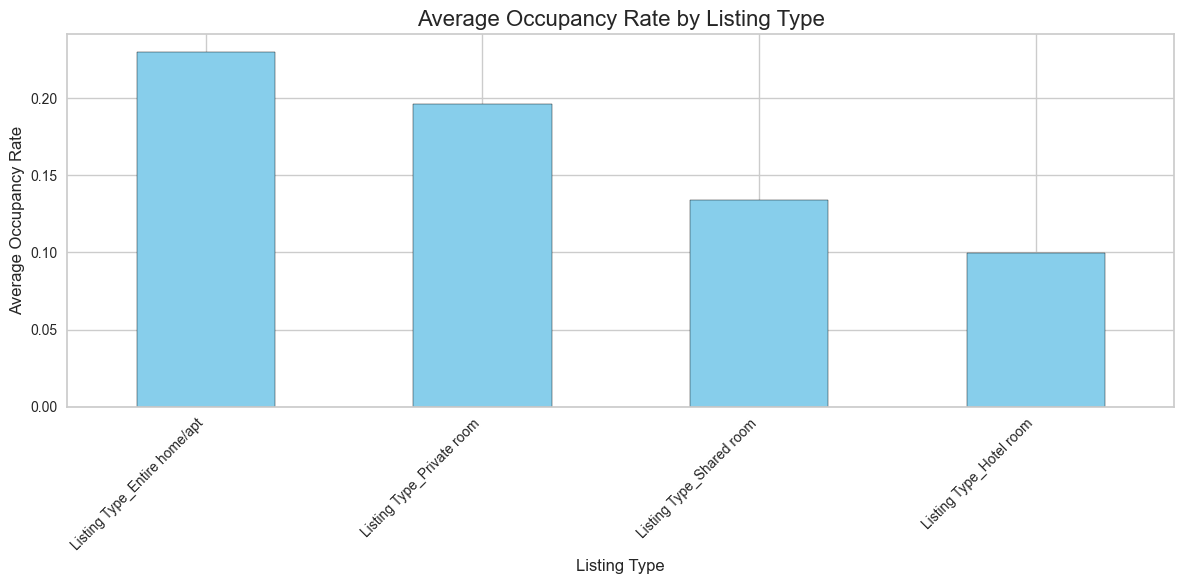

In [18]:
# Copy host_data
listing_data = host_data.copy()

# Filter variables starting with 'Listing Type' and create dummy variables
if len(set(listing_data['Listing Type'])) > 1:
    listing_data = pd.get_dummies(listing_data, columns=['Listing Type'], drop_first=False)

# Filter the newly created dummy columns
dummy_cols = [col for col in listing_data.columns if col.startswith('Listing Type')]

# Calculate the mean occupancy rate for each listing type
listing_avg = (
    listing_data[dummy_cols + ['occupancy_rate']]
    .melt(id_vars=['occupancy_rate'], var_name='Listing Type', value_name='Indicator')
)

# Filter rows where the indicator is 1 (active listing type)
listing_avg_filtered = listing_avg[listing_avg['Indicator'] == 1]

# Calculate the mean occupancy rate by listing type
average_occupancy = (
    listing_avg_filtered.groupby('Listing Type')['occupancy_rate']
    .mean()
    .sort_values(ascending=False)
)

print(dummy_cols)

# Plot the results
plt.figure(figsize=(12, 6))
average_occupancy.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Occupancy Rate by Listing Type', fontsize=16)
plt.ylabel('Average Occupancy Rate', fontsize=12)
plt.xlabel('Listing Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### f. Dummy variable

- Significant variables:
    - host_is_superhost_in_period
    - prev_host_is_superhost
    - superhost_change
    - Pets Allowed
    - Instantbook Enabled

In [19]:
cols = ['host_is_superhost_in_period', 'prev_host_is_superhost', 'superhost_change', 'Pets Allowed', 'Instantbook Enabled']

In [20]:
X = feature_df[cols]
X = sm.add_constant(X)  # Add a constant for the intercept

for col in X.columns:
  if X[col].dtype == 'bool':
    X[col] = X[col].astype(int)

# Fit the logistic regression model
logit_model = sm.OLS(y, X).fit()

# Summarize the results
print(logit_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Superhost   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.732e+30
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:16:30   Log-Likelihood:             1.6388e+06
No. Observations:               54937   AIC:                        -3.278e+06
Df Residuals:                   54931   BIC:                        -3.278e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

### g. Significant interaction terms

- Variables highly correlated with 'occupancy_rate' (|correlation| > 0.3):
    - booked_days                      0.521516
    - revenue                          0.405836
    - prev_available_days             -0.325066
    - available_days                  -0.473119

- Useful interaction term:
    - Bedrooms_x_Bathrooms	                                -0.003901
    - booked_days_period_city_x_revenue_period_city	        -0.000354
    - revenue_period_tract_x_tract_revenue_share	         0.000965
    - scrapes_in_period_x_superhost_observed_in_period      -0.005520
    - host_is_superhost_in_period_x_Superhost               -0.002665
    - rating_ave_pastYear_x_prop_5_StarReviews_pastYear     -0.001374
    - numReviews_pastYear_x_num_5_star_Rev_pastYear         -0.000259
    - available_days_aveListedPrice_x_booked_days_av...     -0.000319
    - Longitude_x_census_tract                              -0.000051
    - tract_superhosts_ratio_x_tract_prev_superhosts...     -0.000096
    - booked_days_period_tract_x_revenue_period_tract        0.000211

- Model accuracy:
    - Mean Squared Error: 0.011732170219778229
    - R-squared: 0.6735039142145582

In [21]:
corr_df = feature_df.copy()
corr_df['occupancy_rate'] = host_data['occupancy_rate']

# Filter numeric columns only
numeric_cols = corr_df.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix
correlation_matrix = corr_df[numeric_cols].corr()

# # Find metrics highly correlated with occupancy_rate
threshold = 0.3
occupancy_rate_corr = correlation_matrix['occupancy_rate']
high_corr_with_occupancy_rate = occupancy_rate_corr[abs(occupancy_rate_corr) > threshold].sort_values(ascending=False)

print("Variables highly correlated with 'occupancy_rate' (|correlation| > 0.3):")
print(high_corr_with_occupancy_rate)

Variables highly correlated with 'occupancy_rate' (|correlation| > 0.3):
occupancy_rate         1.000000
booked_days            0.521516
revenue                0.405836
prev_available_days   -0.325066
available_days        -0.473119
Name: occupancy_rate, dtype: float64


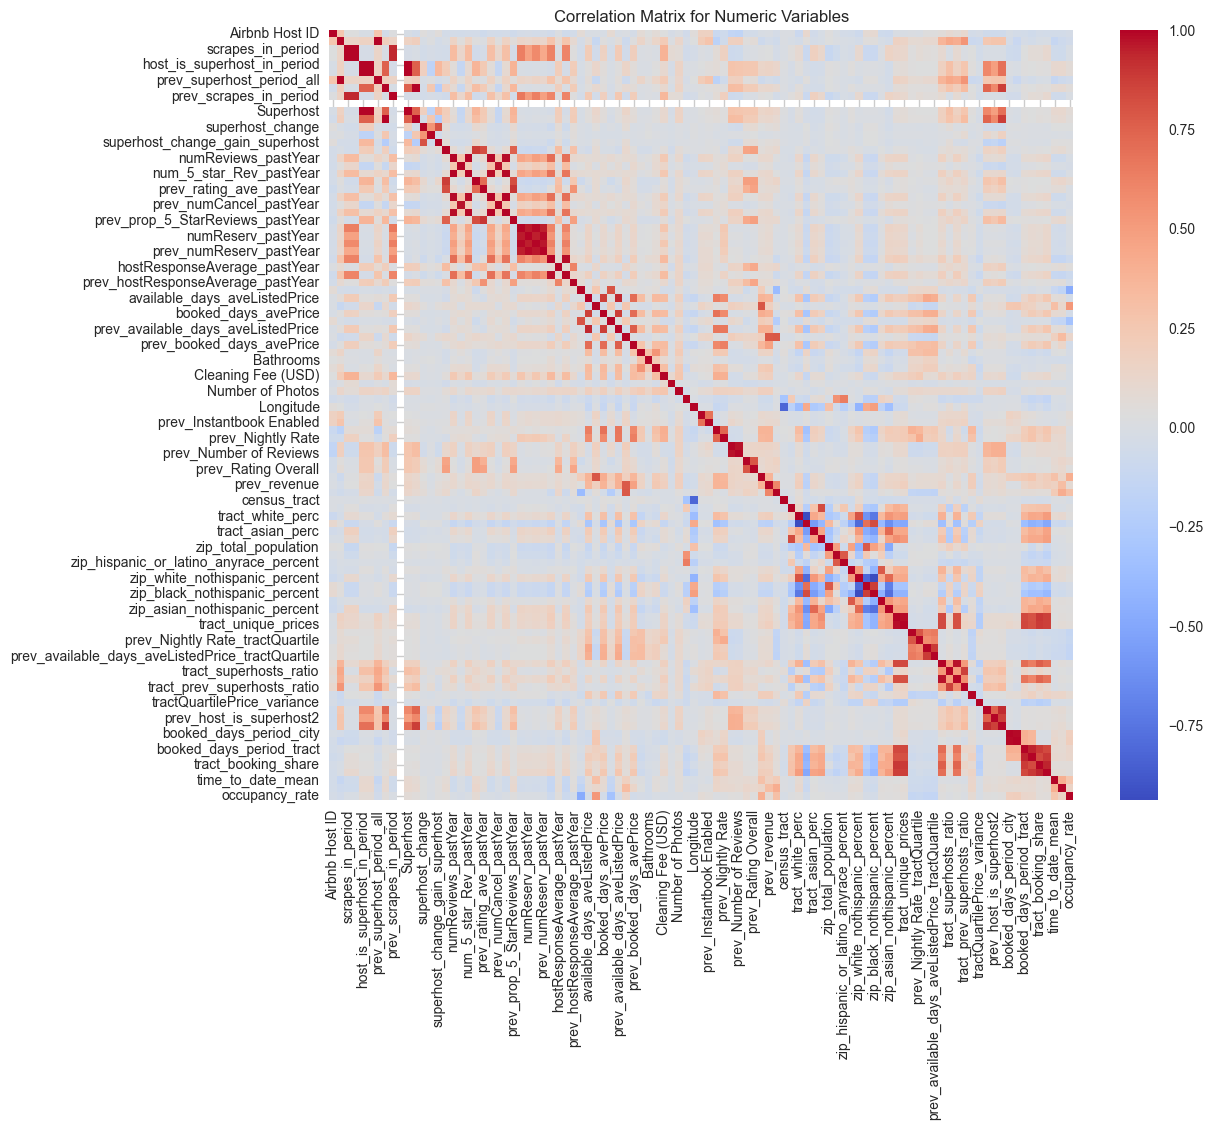

In [22]:
# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for Numeric Variables')
plt.show()


In [23]:
def create_interaction_features(df, threshold=0.8):
    correlation_matrix = df.corr()
    interaction_features = []
    
    for i in range(correlation_matrix.shape[0]):
        for j in range(i + 1, correlation_matrix.shape[1]):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                feature1 = correlation_matrix.index[i]
                feature2 = correlation_matrix.columns[j]
                interaction_name = f"{feature1}_x_{feature2}"
                df[interaction_name] = df[feature1] * df[feature2]  # 创建交互项
                interaction_features.append(interaction_name)
    
    return df, interaction_features

# 1. Set the data
X = feature_df.drop(columns=['Airbnb Host ID']) # .select_dtypes(include=[np.number]).fillna(0)
y = host_data['occupancy_rate']  # 填充目标变量缺失值

# 2. Delete columns that contain prev_
X = X.loc[:, ~X.columns.str.startswith('prev_')]

# 3: Create interaction feature based on correlation > 0.8
X, interaction_features = create_interaction_features(X)

# 4: Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4: Split data into train, test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [24]:
lasso = Lasso(random_state=42)

# Define alpha possible range
alpha_values = np.logspace(-4, 0, 50)


# Use GridSearchCV serch for best alpha
lasso_cv = GridSearchCV(estimator=Lasso(random_state=42), 
                        param_grid={'alpha': alpha_values}, 
                        scoring='r2', 
                        cv=5)

# Find best alpha
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Use best alpha initialize Lasso model
lasso_best = Lasso(alpha=best_alpha, random_state=42, max_iter=5000)

# Train model
lasso_best.fit(X_train, y_train)

# Get model codfficients
lasso_coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_best.coef_
})

# Test model
y_pred = lasso_best.predict(X_test)

# Calculate accuracy
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Best alpha: 0.00021209508879201905
Mean Squared Error: 0.011732170219778229
R-squared: 0.6735039142145582


In [30]:
# Filter features with non-zero coefficients
significant_features = lasso_coefficients[lasso_coefficients['Coefficient'] != 0]

pd.set_option('display.max_rows', None)  # Show all rows

print("Significant features selected by Lasso:")
print(significant_features)

Significant features selected by Lasso:
                                               Feature  Coefficient
0                                 superhost_period_all     0.003124
1                                    scrapes_in_period     0.005941
2                         superhost_observed_in_period     0.000164
3                          host_is_superhost_in_period    -0.001028
4                                      superhost_ratio    -0.000097
8                      superhost_change_lose_superhost    -0.001459
9                      superhost_change_gain_superhost     0.000621
12                                  numCancel_pastYear    -0.000644
16                                  numReserv_pastYear    -0.002509
18                        hostResponseAverage_pastYear    -0.003416
19                                      available_days    -0.125623
20                       available_days_aveListedPrice     0.001611
21                                         booked_days     0.134621
23      

### h. Final prediction model
- Mean Squared Error: 0.0009519123145322582
- R-squared: 0.9579806412686089

In [35]:
traing_cols = [
    # Variables from (a)
    'Nightly Rate',
    'rating_ave_pastYear',

    # Variables from (b)
    'booked_days',
    'rating_ave_pastYear',
    'Max Guests',
    'prev_available_days',
    'prev_numReserv_pastYear',
    'prev_Number of Reviews',
    'Rating Overall',
    'prev_revenue',
    'revenue_period_tract',
    'tract_revenue_share',
    'Pets Allowed',
    'prev_rating_ave_pastYear',
    'prev_booked_days',
    'available_days',
    'prev_year_superhosts',
    'prev_Rating Overall',
    'prev_num_5_star_Rev_pastYear',
    'Number of Photos',
    'prev_time_to_date_mean',
    'Number of Reviews',
    'Cleaning Fee (USD)',
    'prev_booked_days_avePrice',
    'time_to_date_mean',
    'booked_days_period_tract',
    'tract_housing_units',

    # Variables from (c)
    'prev_host_is_superhost_in_period',

    # Variables from (d)
    'host_is_superhost_in_period',
    'Superhost',
    'superhost_change_gain_superhost',
    'prev_host_is_superhost_in_period',
    'prev_host_is_superhost',
    'prev_year_superhosts',
    'rating_ave_pastYear',
    'prev_hostResponseNumber_pastYear',
    'tract_unique_prices',
    'hostResponseAverage_pastYear',
    'prev_Nightly Rate',
    'tract_price_variance',
    'superhost_change_lose_superhost',
    'prev_host_is_superhost2',
    'prev_host_is_superhost1',
    'superhost_ratio',
    'superhost_change',
    'prev_rating_ave_pastYear',
    'hostResponseNumber_pastYear',
    'tract_housing_units',
    'census_tract',

    # Variables from (e)
    'Listing Type_Entire home/apt', 
    'Listing Type_Private room', 
    'Listing Type_Shared room',
    'Listing Type_Hotel room',

    # Variables from (f)
    'host_is_superhost_in_period',
    'prev_host_is_superhost',
    'superhost_change',
    'Pets Allowed',
    'Instantbook Enabled',

    # Variables from (g)
    'scrapes_in_period_x_superhost_observed_in_period',
    'host_is_superhost_in_period_x_Superhost',
    'rating_ave_pastYear_x_prop_5_StarReviews_pastYear',
    'numReviews_pastYear_x_num_5_star_Rev_pastYear',
    'Longitude_x_census_tract',
    'booked_days_period_tract_x_revenue_period_tract',
]

traing_cols = list(set(traing_cols))
print(len(traing_cols))

54


In [36]:
X = feature_df.drop(columns=['Airbnb Host ID']) 
y = host_data['occupancy_rate']

# 1. Create interaction feature based on correlation > 0.8
X, interaction_features = create_interaction_features(X)

# 2. Split data into train, test
X_train, X_test, y_train, y_test = train_test_split(X[traing_cols], y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(
    n_estimators=100,  # 树的数量
    learning_rate=0.1,  # 学习率
    max_depth=4,       # 每棵树的最大深度
    random_state=42    # 随机种子
)

# 3. Train model
gbr.fit(X_train, y_train)

# 4. Predict data
y_pred = gbr.predict(X_test)

# 5. Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 8.281407085351751e-05
R-squared: 0.9976953564877494
